In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## variables

In [5]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [6]:
hg19_elems_f = "../../../misc/03__nearby_elems/hg19.num_elems_1Mb.bed"
mm9_elems_f = "../../../misc/03__nearby_elems/mm9.num_elems_1Mb.bed"

In [7]:
hg19_tss_f = "../../../misc/03__nearby_elems/hg19.num_TSSs_1Mb.bed"
mm9_tss_f = "../../../misc/03__nearby_elems/mm9.num_TSSs_1Mb.bed"

In [8]:
hg19_enh_f = "../../../misc/03__nearby_elems/hg19.num_enhs_1Mb.bed"
mm9_enh_f = "../../../misc/03__nearby_elems/mm9.num_enhs_1Mb.bed"

## 1. import data

In [9]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


In [10]:
hg19_elems = pd.read_table(hg19_elems_f, sep="\t", header=None)
hg19_tss = pd.read_table(hg19_tss_f, sep="\t", header=None)
hg19_enh = pd.read_table(hg19_enh_f, sep="\t", header=None)
hg19_elems.columns = ["chr", "start", "end", "name", "n_elems_hg19"]
hg19_tss.columns = ["chr", "start", "end", "name", "n_tss_hg19"]
hg19_enh.columns = ["chr", "start", "end", "name", "n_enh_hg19"]
hg19_elems.head()

,chr,start,end,name,n_elems_hg19
0,chr1,355317,2355461,HUMAN_EVO_TSS__h.1539__tile2;WT,531
1,chr1,355431,2355575,HUMAN_EVO_TSS__h.1539__tile1;WT,531
2,chr1,447313,2447457,HUMAN_EVO_TSS__h.3020__tile2;WT,549
3,chr1,447388,2447532,HUMAN_EVO_TSS__h.2871__tile1;WT,549
4,chr1,447427,2447571,HUMAN_EVO_TSS__h.3020__tile1;WT,549


In [11]:
mm9_elems = pd.read_table(mm9_elems_f, sep="\t", header=None)
mm9_tss = pd.read_table(mm9_tss_f, sep="\t", header=None)
mm9_enh = pd.read_table(mm9_enh_f, sep="\t", header=None)
mm9_elems.columns = ["chr", "start", "end", "name", "n_elems_mm9"]
mm9_tss.columns = ["chr", "start", "end", "name", "n_tss_mm9"]
mm9_enh.columns = ["chr", "start", "end", "name", "n_enh_mm9"]
mm9_elems.head()

,chr,start,end,name,n_elems_mm9
0,chr1,9983171,11983315,MOUSE_EVO_TSS__m.730__tile2;WT,57
1,chr1,9983285,11983429,MOUSE_EVO_TSS__m.730__tile1;WT,57
2,chr1,11981773,13981917,MOUSE_EVO_TSS__m.1555__tile2;WT,94
3,chr1,11981887,13982031,MOUSE_EVO_TSS__m.1555__tile1;WT,94
4,chr1,11982791,13982935,MOUSE_EVO_TSS__m.986__tile1;WT,94


## 2. join data w/ number of nearby elements

In [12]:
hg19_elems["hg19_id"] = hg19_elems["name"].str.split("__", expand=True)[1]
hg19_elems["tss_tile_num"] = hg19_elems["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
hg19_tss["hg19_id"] = hg19_tss["name"].str.split("__", expand=True)[1]
hg19_tss["tss_tile_num"] = hg19_tss["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
hg19_enh["hg19_id"] = hg19_enh["name"].str.split("__", expand=True)[1]
hg19_enh["tss_tile_num"] = hg19_enh["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
hg19_elems.head()

,chr,start,end,name,n_elems_hg19,hg19_id,tss_tile_num
0,chr1,355317,2355461,HUMAN_EVO_TSS__h.1539__tile2;WT,531,h.1539,tile2
1,chr1,355431,2355575,HUMAN_EVO_TSS__h.1539__tile1;WT,531,h.1539,tile1
2,chr1,447313,2447457,HUMAN_EVO_TSS__h.3020__tile2;WT,549,h.3020,tile2
3,chr1,447388,2447532,HUMAN_EVO_TSS__h.2871__tile1;WT,549,h.2871,tile1
4,chr1,447427,2447571,HUMAN_EVO_TSS__h.3020__tile1;WT,549,h.3020,tile1


In [13]:
mm9_elems["mm9_id"] = mm9_elems["name"].str.split("__", expand=True)[1]
mm9_elems["tss_tile_num"] = mm9_elems["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
mm9_tss["mm9_id"] = mm9_tss["name"].str.split("__", expand=True)[1]
mm9_tss["tss_tile_num"] = mm9_tss["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
mm9_enh["mm9_id"] = mm9_enh["name"].str.split("__", expand=True)[1]
mm9_enh["tss_tile_num"] = mm9_enh["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
mm9_elems.head()

,chr,start,end,name,n_elems_mm9,mm9_id,tss_tile_num
0,chr1,9983171,11983315,MOUSE_EVO_TSS__m.730__tile2;WT,57,m.730,tile2
1,chr1,9983285,11983429,MOUSE_EVO_TSS__m.730__tile1;WT,57,m.730,tile1
2,chr1,11981773,13981917,MOUSE_EVO_TSS__m.1555__tile2;WT,94,m.1555,tile2
3,chr1,11981887,13982031,MOUSE_EVO_TSS__m.1555__tile1;WT,94,m.1555,tile1
4,chr1,11982791,13982935,MOUSE_EVO_TSS__m.986__tile1;WT,94,m.986,tile1


In [14]:
len(data)

5482

In [15]:
data = data.merge(hg19_elems[["hg19_id", "tss_tile_num", "n_elems_hg19"]], on=["hg19_id", "tss_tile_num"], how="left")
data = data.merge(hg19_tss[["hg19_id", "tss_tile_num", "n_tss_hg19"]], on=["hg19_id", "tss_tile_num"], how="left")
data = data.merge(hg19_enh[["hg19_id", "tss_tile_num", "n_enh_hg19"]], on=["hg19_id", "tss_tile_num"], how="left")

data = data.merge(mm9_elems[["mm9_id", "tss_tile_num", "n_elems_mm9"]], on=["mm9_id", "tss_tile_num"], how="left")
data = data.merge(mm9_tss[["mm9_id", "tss_tile_num", "n_tss_mm9"]], on=["mm9_id", "tss_tile_num"], how="left")
data = data.merge(mm9_enh[["mm9_id", "tss_tile_num", "n_enh_mm9"]], on=["mm9_id", "tss_tile_num"], how="left")
print(len(data))
data.head()

5482


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,n_elems_hg19,n_tss_hg19,n_enh_hg19,n_elems_mm9,n_tss_mm9,n_enh_mm9
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect,345,267,78.0,318.0,244.0,74.0
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect,278,185,93.0,313.0,219.0,94.0
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect,418,343,75.0,510.0,357.0,153.0
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect,192,150,42.0,116.0,93.0,23.0
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect,192,150,42.0,116.0,93.0,23.0


## 3. look at overall numbers of nearby elems in human and mouse

In [16]:
# remove the 1 seq that is on chr1_random in mouse
data = data[~pd.isnull(data["n_elems_mm9"])]

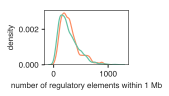

In [17]:
fig = plt.figure(figsize=(1.5, 1))

ax = sns.distplot(data["n_elems_hg19"], color=sns.color_palette("Set2")[1], label="human", hist=False)
sns.distplot(data["n_elems_mm9"], color=sns.color_palette("Set2")[0], label="mouse", hist=False)

ax.set_xlabel("number of regulatory elements within 1 Mb")
ax.set_ylabel("density")
ax.get_legend().remove()

fig.savefig("n_elems_distplot.pdf", dpi="figure", bbox_inches="tight")

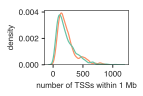

In [18]:
fig = plt.figure(figsize=(1.5, 1))

ax = sns.distplot(data["n_tss_hg19"], color=sns.color_palette("Set2")[1], label="human", hist=False)
sns.distplot(data["n_tss_mm9"], color=sns.color_palette("Set2")[0], label="mouse", hist=False)

ax.set_xlabel("number of TSSs within 1 Mb")
ax.set_ylabel("density")
ax.get_legend().remove()

fig.savefig("n_tss_distplot.pdf", dpi="figure", bbox_inches="tight")

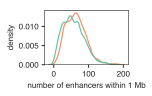

In [19]:
fig = plt.figure(figsize=(1.5, 1))

ax = sns.distplot(data["n_enh_hg19"], color=sns.color_palette("Set2")[1], label="human", hist=False)
sns.distplot(data["n_enh_mm9"], color=sns.color_palette("Set2")[0], label="mouse", hist=False)

ax.set_xlabel("number of enhancers within 1 Mb")
ax.set_ylabel("density")
ax.get_legend().remove()

fig.savefig("n_enh_distplot.pdf", dpi="figure", bbox_inches="tight")

In [20]:
data["mean_elems"] = data[["n_elems_hg19", "n_elems_mm9"]].mean(axis=1)
data["mean_tss"] = data[["n_tss_hg19", "n_tss_mm9"]].mean(axis=1)
data["mean_enh"] = data[["n_enh_hg19", "n_enh_mm9"]].mean(axis=1)

## 4. assign directional vs. compensatory status and filter

In [21]:
def cis_trans_status(row):
    if row.cis_status_one == "significant cis effect":
        if row.trans_status_one == "significant trans effect":
            if "higher in human" in row.cis_status_det_one:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans directional"
                else:
                    return "cis/trans compensatory"
            else:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans compensatory"
                else:
                    return "cis/trans directional"
        else:
            return "cis effect only"
    else:
        if row.trans_status_one == "significant trans effect":
            return "trans effect only"
        else:
            return "no cis or trans effects"

In [22]:
data["cis_trans_status"] = data.apply(cis_trans_status, axis=1)
data.cis_trans_status.value_counts()

no cis or trans effects    3738
cis effect only            1220
trans effect only           274
cis/trans directional       147
cis/trans compensatory      102
Name: cis_trans_status, dtype: int64

In [23]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

5437

In [24]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

2284

In [25]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

2271

In [26]:
data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
len(data_filt_tile1)

1392

In [27]:
data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
len(data_filt_tile1_sp)

1382

In [28]:
data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
len(data_filt_tile2)

892

In [29]:
data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
len(data_filt_tile2_sp)

889

In [30]:
dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
titles = ["both tiles", "tile1 only", "tile2 only"]
labels = ["both_tiles", "tile1_only", "tile2_only"]

## 5. look at reg elems vs. cis/trans status

In [31]:
order = ["no cis or trans effects", "cis/trans compensatory", "cis effect only", "trans effect only",
         "cis/trans directional"]
min_order = ["cis/trans compensatory", "cis/trans directional"]
pal = {"no cis or trans effects": sns.color_palette("Set2")[7], "cis effect only": sns.color_palette("Set2")[2],
       "trans effect only": sns.color_palette("Set2")[2], "cis/trans directional": sns.color_palette("Set2")[2],
       "cis/trans compensatory": sns.color_palette("Set2")[7]}

### all REs

cis/trans compensatory median REs: 230.0
cis/trans directional median REs: 247.0
cis/trans compensatory median REs: 221.0
cis/trans directional median REs: 246.0
cis/trans compensatory median REs: 271.0
cis/trans directional median REs: 255.5


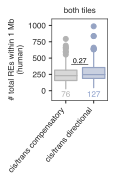

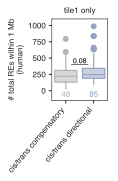

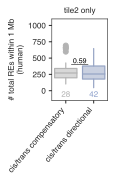

In [32]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="n_elems_hg19", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# total REs within 1 Mb\n(human)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["n_elems_hg19"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["n_elems_hg19"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["n_elems_hg19"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1100))
    ax.set_title(title)
    fig.savefig("cis_trans_n_elems_hg19.%s.pdf" % label, dpi="figure", bbox_inches="tight")

cis/trans compensatory median REs: 200.0
cis/trans directional median REs: 260.0
cis/trans compensatory median REs: 177.0
cis/trans directional median REs: 260.0
cis/trans compensatory median REs: 206.5
cis/trans directional median REs: 251.5


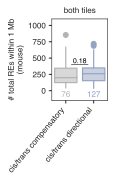

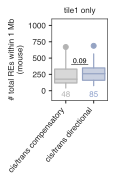

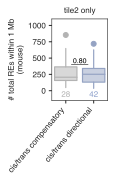

In [33]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="n_elems_mm9", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# total REs within 1 Mb\n(mouse)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["n_elems_mm9"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["n_elems_mm9"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["n_elems_mm9"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1100))
    ax.set_title(title)
    fig.savefig("cis_trans_n_elems_mm9.%s.pdf" % label, dpi="figure", bbox_inches="tight")

cis/trans compensatory median REs: 229.75
cis/trans directional median REs: 234.5
cis/trans compensatory median REs: 207.25
cis/trans directional median REs: 234.5
cis/trans compensatory median REs: 237.75
cis/trans directional median REs: 227.0


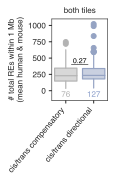

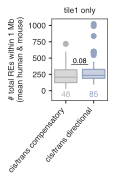

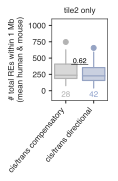

In [34]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="mean_elems", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# total REs within 1 Mb\n(mean human & mouse)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["mean_elems"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["mean_elems"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["mean_elems"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1100))
    ax.set_title(title)
    fig.savefig("cis_trans_n_elems_mean.%s.pdf" % label, dpi="figure", bbox_inches="tight")

### TSSs only

cis/trans compensatory median REs: 183.0
cis/trans directional median REs: 185.0
cis/trans compensatory median REs: 165.5
cis/trans directional median REs: 185.0
cis/trans compensatory median REs: 191.0
cis/trans directional median REs: 180.5


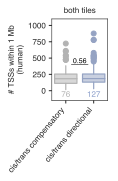

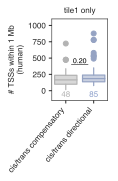

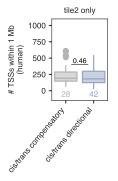

In [35]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="n_tss_hg19", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# TSSs within 1 Mb\n(human)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["n_tss_hg19"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["n_tss_hg19"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["n_tss_hg19"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1100))
    ax.set_title(title)
    fig.savefig("cis_trans_n_tss_hg19.%s.pdf" % label, dpi="figure", bbox_inches="tight")

cis/trans compensatory median REs: 143.0
cis/trans directional median REs: 188.0
cis/trans compensatory median REs: 128.0
cis/trans directional median REs: 188.0
cis/trans compensatory median REs: 153.5
cis/trans directional median REs: 190.5


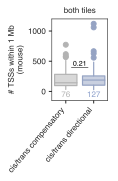

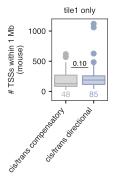

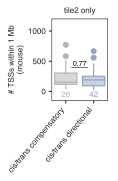

In [37]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="n_tss_mm9", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# TSSs within 1 Mb\n(mouse)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["n_tss_mm9"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["n_tss_mm9"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["n_tss_mm9"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1200))
    ax.set_title(title)
    fig.savefig("cis_trans_n_tss_mm9.%s.pdf" % label, dpi="figure", bbox_inches="tight")

cis/trans compensatory median REs: 156.5
cis/trans directional median REs: 166.0
cis/trans compensatory median REs: 148.5
cis/trans directional median REs: 166.0
cis/trans compensatory median REs: 176.0
cis/trans directional median REs: 167.75


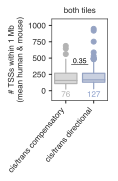

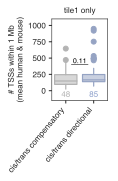

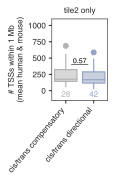

In [38]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="mean_tss", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# TSSs within 1 Mb\n(mean human & mouse)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["mean_tss"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["mean_tss"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["mean_tss"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1100))
    ax.set_title(title)
    fig.savefig("cis_trans_n_tss_mean.%s.pdf" % label, dpi="figure", bbox_inches="tight")

### enhancers only

cis/trans compensatory median REs: 53.5
cis/trans directional median REs: 63.0
cis/trans compensatory median REs: 47.0
cis/trans directional median REs: 63.0
cis/trans compensatory median REs: 55.5
cis/trans directional median REs: 62.5


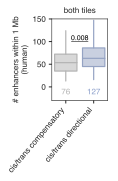

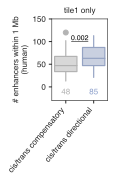

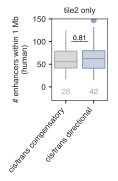

In [42]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="n_enh_hg19", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# enhancers within 1 Mb\n(human)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["n_enh_hg19"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -20), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["n_enh_hg19"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["n_enh_hg19"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 100, 0, 100, pval12, fontsize-1)
    
    ax.set_ylim((-30, 150))
    ax.set_title(title)
    fig.savefig("cis_trans_n_enh_hg19.%s.pdf" % label, dpi="figure", bbox_inches="tight")

cis/trans compensatory median REs: 143.0
cis/trans directional median REs: 188.0
cis/trans compensatory median REs: 128.0
cis/trans directional median REs: 188.0
cis/trans compensatory median REs: 153.5
cis/trans directional median REs: 190.5


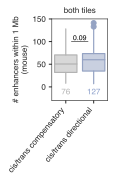

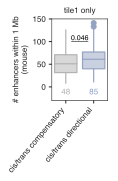

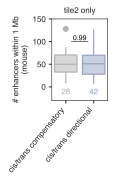

In [44]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="n_enh_mm9", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# enhancers within 1 Mb\n(mouse)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["n_tss_mm9"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -20), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["n_enh_mm9"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["n_enh_mm9"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 100, 0, 100, pval12, fontsize-1)
    
    ax.set_ylim((-30, 150))
    ax.set_title(title)
    fig.savefig("cis_trans_n_enh_mm9.%s.pdf" % label, dpi="figure", bbox_inches="tight")

cis/trans compensatory median REs: 156.5
cis/trans directional median REs: 166.0
cis/trans compensatory median REs: 148.5
cis/trans directional median REs: 166.0
cis/trans compensatory median REs: 176.0
cis/trans directional median REs: 167.75


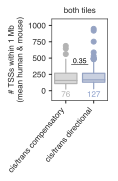

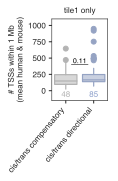

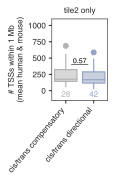

In [38]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1, 1.5))

    ax = sns.boxplot(data=df, x="cis_trans_status", y="mean_tss", order=min_order, 
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("# TSSs within 1 Mb\n(mean human & mouse)")
    
    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median REs: %s" % (l, sub["mean_tss"].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["mean_tss"])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["mean_tss"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)
    
    ax.set_ylim((-150, 1100))
    ax.set_title(title)
    fig.savefig("cis_trans_n_tss_mean.%s.pdf" % label, dpi="figure", bbox_inches="tight")